In [29]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [31]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [32]:
[eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]

['ssp370SST-lowNTCF',
 'ssp370SST-lowCH4',
 'ssp370-lowNTCF',
 'ssp370SST-ssp126Lu',
 'ssp370pdSST',
 'ssp370SST',
 'esm-ssp585',
 'ssp126-ssp370Lu',
 'esm-ssp585-ssp126Lu',
 'ssp585',
 'ssp370',
 'ssp370-ssp126Lu',
 'ssp245',
 'ssp119',
 'ssp126',
 'ssp245-nat',
 'ssp245-GHG',
 'ssp434',
 'ssp460',
 'ssp534-over',
 'ssp245-stratO3',
 'ssp245-aer',
 'ssp245-covid',
 'ssp245-cov-strgreen',
 'ssp245-cov-modgreen',
 'ssp245-cov-fossil',
 'ssp585-bgc']

In [213]:
# there is currently a significant amount of data for these runs
#expts = ['historical', 'ssp245', 'ssp585']
expts = ['historical','ssp245', 'ssp126','ssp370','ssp585']

query = dict(
    experiment_id=expts,
    table_id='Amon',                           
    variable_id=['tas'],
    member_id = 'r1i1p1f1',                     
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,5,1,1
ACCESS-ESM1-5,5,1,1
AWI-CM-1-1-MR,5,1,1
BCC-CSM2-MR,5,1,1
CAMS-CSM1-0,5,1,1
CESM2-WACCM,5,1,1
CMCC-CM2-SR5,5,1,1
CMCC-ESM2,5,1,1
CanESM5,5,1,1


In [214]:
#ds = intake.open_esm_datastore('/Volumes/Transcend/tas_Amon_CAS-ESM2-0_ssp245_r1i1p1f1_gn_201501-210012.nc')
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict) 

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [215]:
dsets_ = dask.compute(dict(dsets))[0]

In [216]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [218]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                        coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue
    
    for ds in expt_dsets:
        #ds.coords['year'] = ds.time.dt.year
        #ds.coords['month']=ds.time.dt.month
        ds.coords['rawmonth']=ds.time.dt.month+(ds.time.dt.year-1850)*12
        #print(ds.coords)
    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_mon_mean = [v[expt].pipe(global_mean)
                             .swap_dims({'time': 'rawmonth'})
                             .drop('time')
                             #.drop('mon')
    #                         .coarsen(year=12).mean()
                      for expt in expts]
    
    #print(dsets_mon_mean)
    
    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_mon_mean, join='outer',
                                 dim=expt_da)

  0%|          | 0/27 [00:00<?, ?it/s]

In [39]:
# expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
#                        coords={'experiment_id': expts})

# dsets_aligned = {}

# for k, v in tqdm(dsets_.items()):
#     expt_dsets = v.values()
#     if any([d is None for d in expt_dsets]):
#         print(f"Missing experiment for {k}")
#         continue
    
#     for ds in expt_dsets:
#         ds.coords['year'] = ds.time.dt.year
        
#     # workaround for
#     # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
#     dsets_ann_mean = [v[expt].pipe(global_mean)
#                              .swap_dims({'time': 'year'})
#                              .drop('time')
#                              .coarsen(year=12).mean()
#                       for expt in expts]
    
#     # align everything with the 4xCO2 experiment
#     dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',
#                                  dim=expt_da)

  0%|          | 0/34 [00:00<?, ?it/s]

In [219]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

[########################################] | 100% Completed | 36min 46.7s


In [162]:
print(type(dsets_aligned_['ACCESS-CM2']))

<class 'xarray.core.dataset.Dataset'>


In [220]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds

<xarray.Dataset>
Dimensions:        (experiment_id: 5, rawmonth: 5412, source_id: 27)
Coordinates:
  * source_id      (source_id) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
  * rawmonth       (rawmonth) int64 1 2 3 4 5 6 ... 5408 5409 5410 5411 5412
  * experiment_id  (experiment_id) <U10 'historical' 'ssp245' ... 'ssp585'
Data variables:
    tas            (source_id, experiment_id, rawmonth) float64 285.2 ... nan

In [156]:
print(type(df_all))
#df_all.to_csv('./df_all_tas_by_month.csv')

<class 'pandas.core.frame.DataFrame'>


In [157]:
df_all.to_netcdf('./df_all_tas_by_month.nc')

AttributeError: 'DataFrame' object has no attribute 'to_netcdf'

In [224]:
df_all = big_ds.sel(rawmonth=slice(1, 5412)).to_dataframe().reset_index()
df_all.head()

,experiment_id,rawmonth,source_id,tas
0,historical,1,ACCESS-CM2,285.191116
1,historical,1,ACCESS-ESM1-5,285.925713
2,historical,1,AWI-CM-1-1-MR,NaN
3,historical,1,BCC-CSM2-MR,285.642202
4,historical,1,CAMS-CSM1-0,285.393356


In [ ]:
sns.relplot(data=df_all,
            x="year", y="tas", hue='experiment_id',
            kind="line", ci="sd", aspect=2);

print(df_all.shape)
df_by_exp = df_all.groupby('experiment_id')

tas_exp = []
for name, group in df_by_exp:
    group_mon = group.groupby('rawmonth')
    tas = np.empty((13,251))
    tas[0,:]=np.arange(1850,2101)
    month = []
    year = []
    for mon, mongroup in group_mon:
        if mon>251:
            break
        montemp = np.nanmean(mongroup['tas'])
        i_month = int(mon%12)
        i_year = int(np.floor(mon/12))
        tas[i_month,i_year] = montemp
    #print(np.count_nonzero(tas))
    #print(np.count_nonzero(np.isnan(tas)))
    tas_exp.append(tas)
    #years = (np.asarray(months)/12)+1850
    #plt.plot(years,avg_temps,label=name,alpha=0.6)
    #plt.show()

In [124]:
indlist = [i%12 for i in np.arange(25)]
print(indlist)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0]


In [223]:
print(names)

['historical', 'ssp245', 'ssp585']


In [225]:
print(df_all.shape)
df_by_exp = df_all.groupby('experiment_id')

tas_exp = []
names = []
for name, group in df_by_exp:
    group_mon = group.groupby('rawmonth')
    tas = np.empty((13,251))
    tas[0,:]=np.arange(1850,2101)
    names.append(name)
    for mon, mongroup in group_mon:
        if mon<3012:
            montemp = np.nanmean(mongroup['tas'])
            i_month = int(mon%12)
            if i_month==0:
                i_month=12
            i_year = int(np.floor(mon/12))
            tas[i_month,i_year] = montemp
    #print(np.count_nonzero(tas))
    #print(np.count_nonzero(np.isnan(tas)))
    tas_exp.append(tas)
    #years = (np.asarray(months)/12)+1850
    #plt.plot(years,avg_temps,label=name,alpha=0.6)
    #plt.show()

(730620, 4)


<ipython-input-225-eb378e5cc32e>:13: RuntimeWarning: Mean of empty slice
  montemp = np.nanmean(mongroup['tas'])


In [121]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [226]:
print(len(tas_exp))
#print(np.count_nonzero(np.isnan(tas_exp[0][12,:])))

5


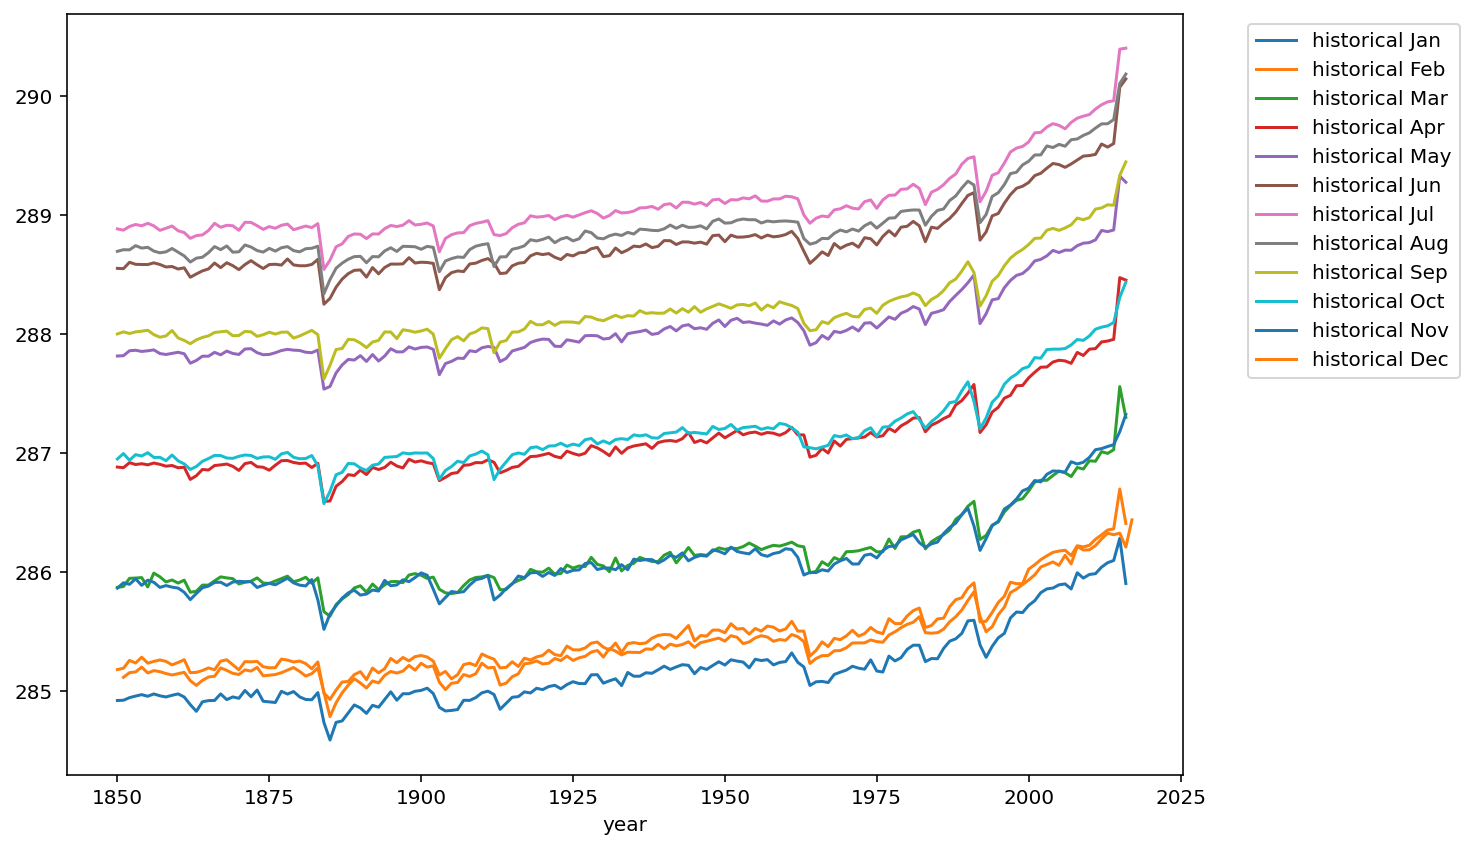

In [158]:
plt.figure(figsize=(10,7))
for j in range(1):
    for i in range(1,13):
        plt.plot(tas_exp[j][0,:],tas_exp[j][i,:],label=names[j]+' '+months[i-1])
plt.xlabel('year')
#plt.xlim(1900,2100)
#plt.ylim(-290,10**100)
plt.legend(bbox_to_anchor=(1.05, 1))

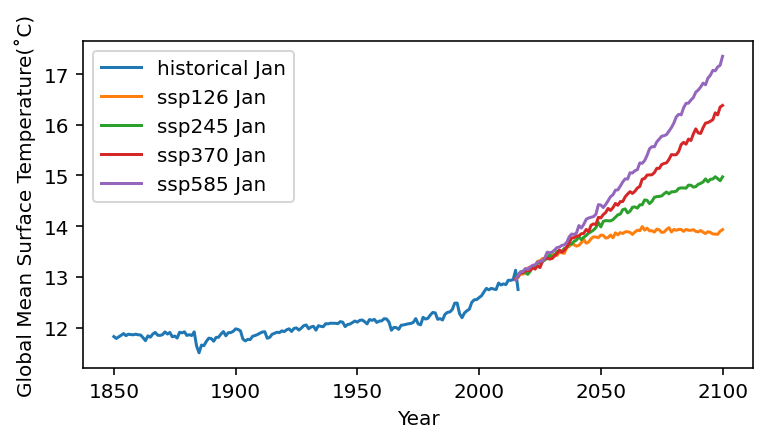

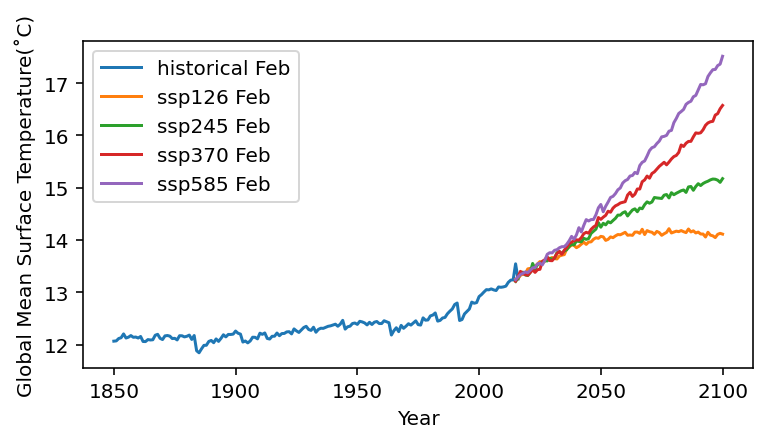

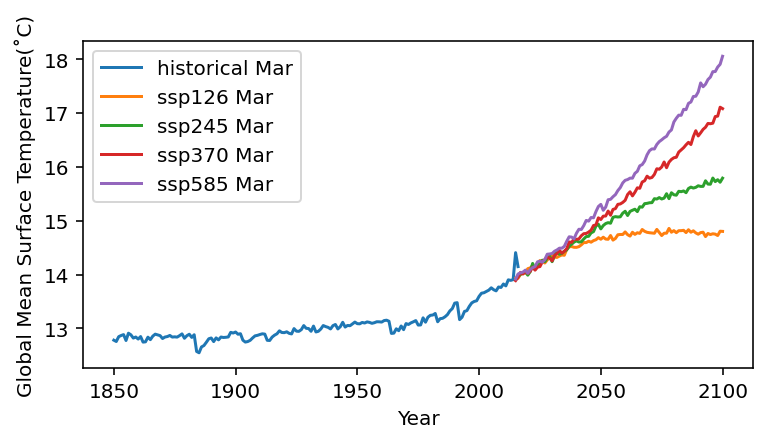

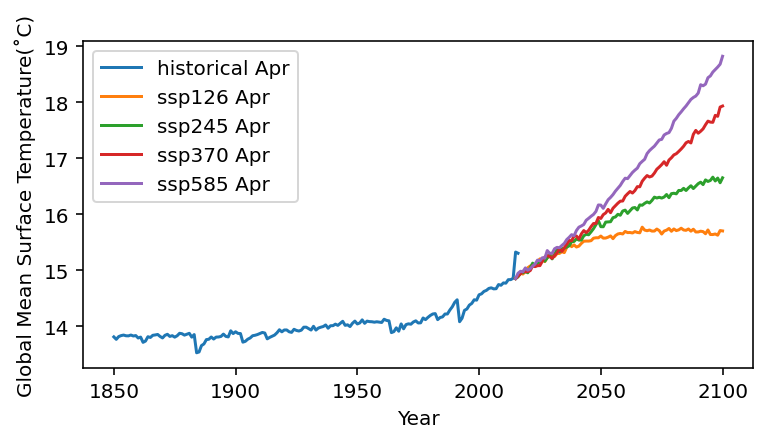

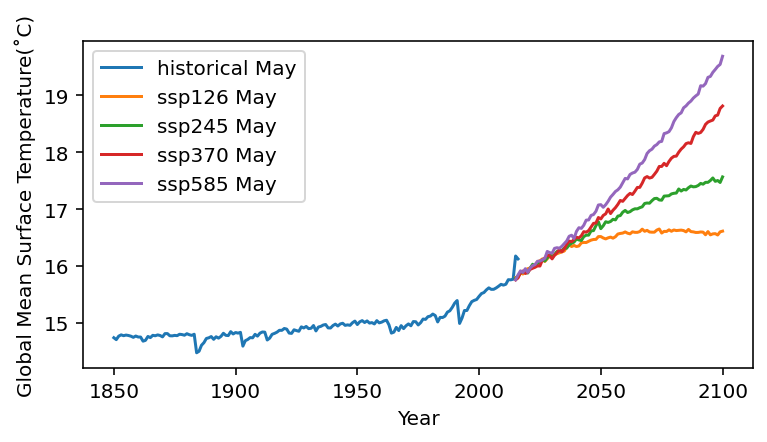

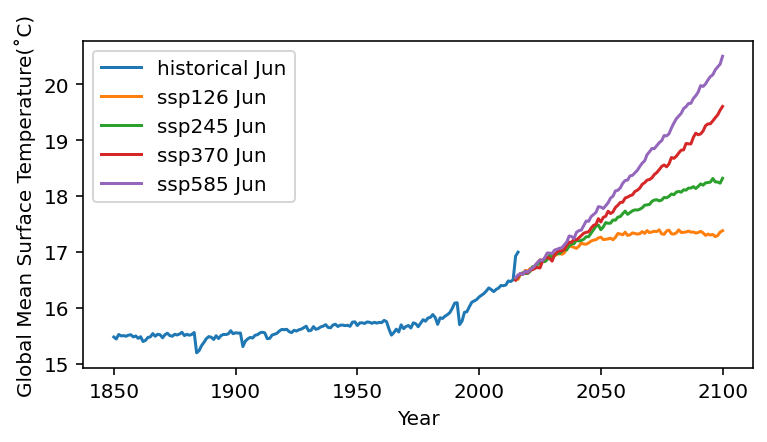

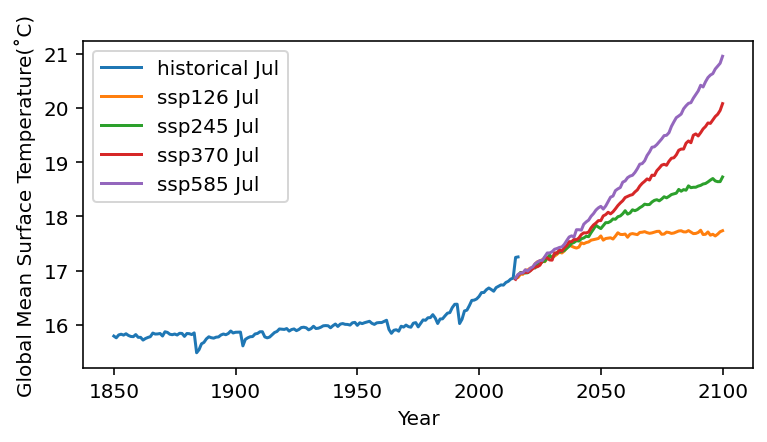

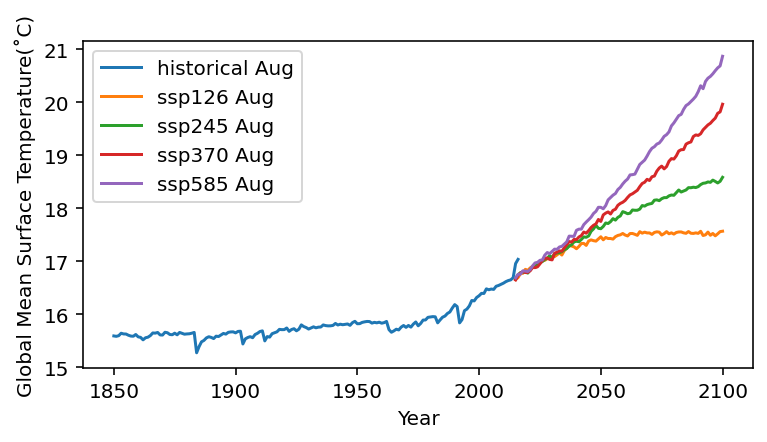

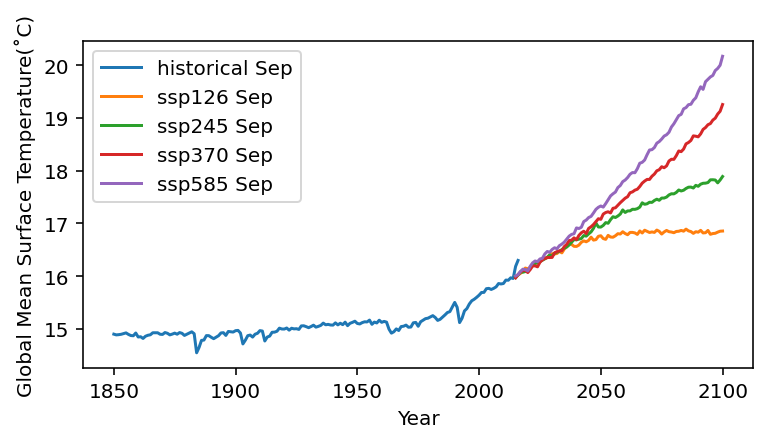

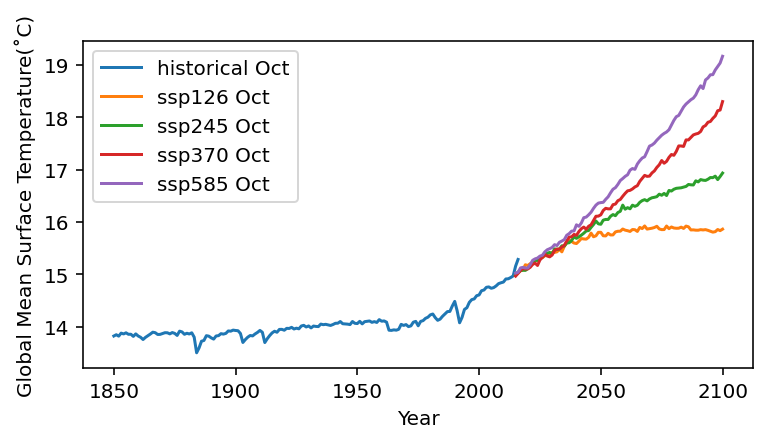

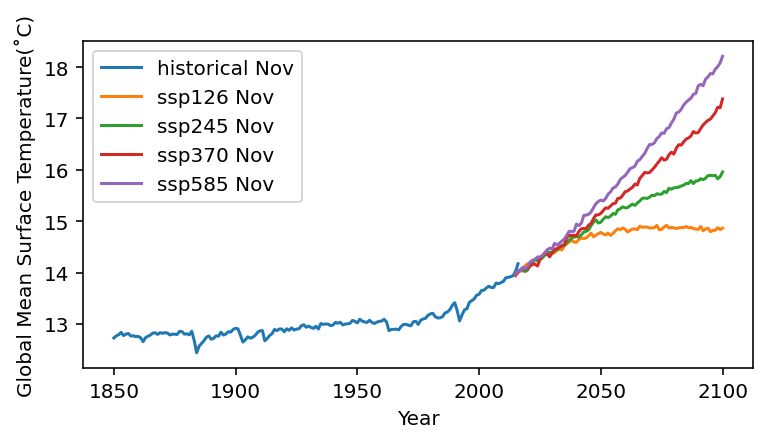

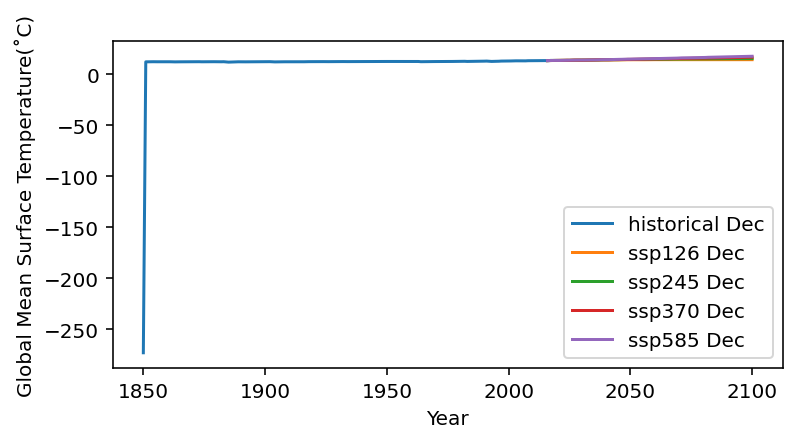

In [227]:
plotmon = np.arange(1,13)
plotset = (0,1,2,3,4)
for i in plotmon:
    plt.figure(figsize=(6,3))
    for j in plotset:
        #if not (i = 13 and j=2):
        plt.plot(tas_exp[j][0,:],tas_exp[j][i,:]-273.15,label=names[j]+' '+months[i-1])
    plt.xlabel('Year')
    plt.ylabel('Global Mean Surface Temperature(˚C)')
    #plt.xlim(1900,2100)
    #plt.ylim(-290,10**100)
    plt.legend()
    plt.show()

In [159]:
tas.shape

(13, 251)

In [228]:
yearavg = np.empty((5,251))
stddevs = np.empty((5,251))
for j in range(5):
    for i in range(tas_exp[j].shape[1]):
        meantas = np.nanmean(tas_exp[j][1:,i])
        yearavg[j,i] = meantas
        std = np.nanstd(tas_exp[j][1:,i])
        stddevs[j,i] = std

<ipython-input-228-2977acf313b4>:5: RuntimeWarning: Mean of empty slice
  meantas = np.nanmean(tas_exp[j][1:,i])
/opt/anaconda3/envs/cicoes37/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [183]:
print(tas_exp[0][-3:,-100:])

[[287.80040888 287.79554077 287.86800656 287.87171619 287.87163788
  287.87662324 287.90725141 287.95269444 287.9453753  287.98290734
  288.03949167 288.0566562  288.06726422 288.09580363 288.30719868
  288.43528497          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan         

(10.0, 20.0)

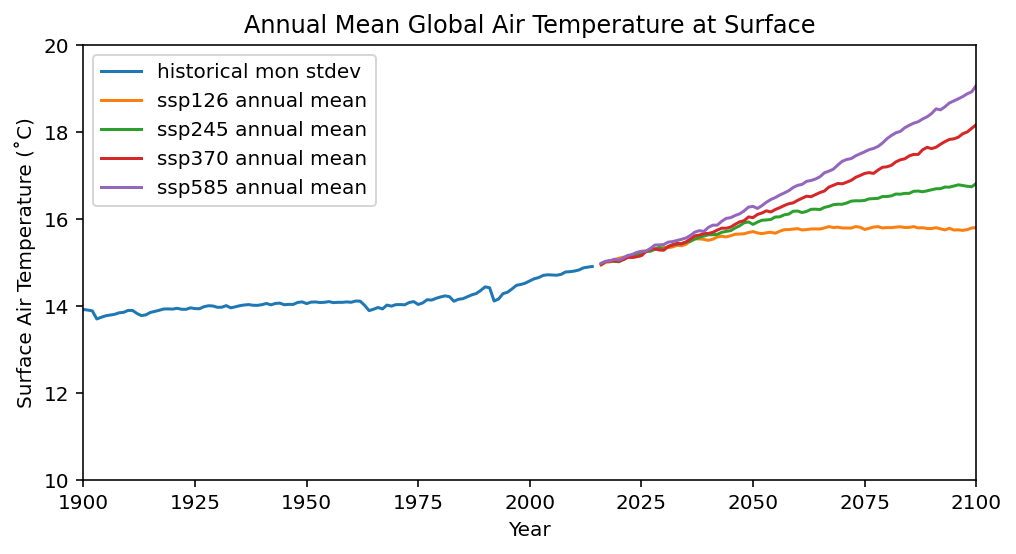

In [234]:
plt.figure(figsize=(8,4))
#plt.plot(tas_exp[0][0,:],stddevs)
plt.plot(tas_exp[0][0,:165],yearavg[0,:165]-273.15,label = 'historical mon stdev')
for j in range(1,5): 
    plt.plot(tas_exp[j][0,166:],yearavg[j,166:]-273.15,label = names[j]+' annual mean')
plt.title('Annual Mean Global Air Temperature at Surface')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Surface Air Temperature (˚C)')
plt.xlim(1900,2100)
plt.ylim(10,20)

In [243]:
startavg = int(np.where(tas_exp[0][0,:]==1981)[0])
endavg = int(np.where(tas_exp[0][0,:]==2015)[0])
monthmeans = []
monthanomalies = np.empty((13,34))
monthanomalies[0,:] = np.arange(1981,2015)
for i in range(1,13):
    meantas = np.nanmean(tas_exp[0][i,startavg:endavg])
    monthmeans.append(meantas)
    for j in range(34):
        monthtemps = tas_exp[0][i,startavg:endavg]
        anomaly = monthtemps[j]-meantas
        monthanomalies[i,j] = anomaly

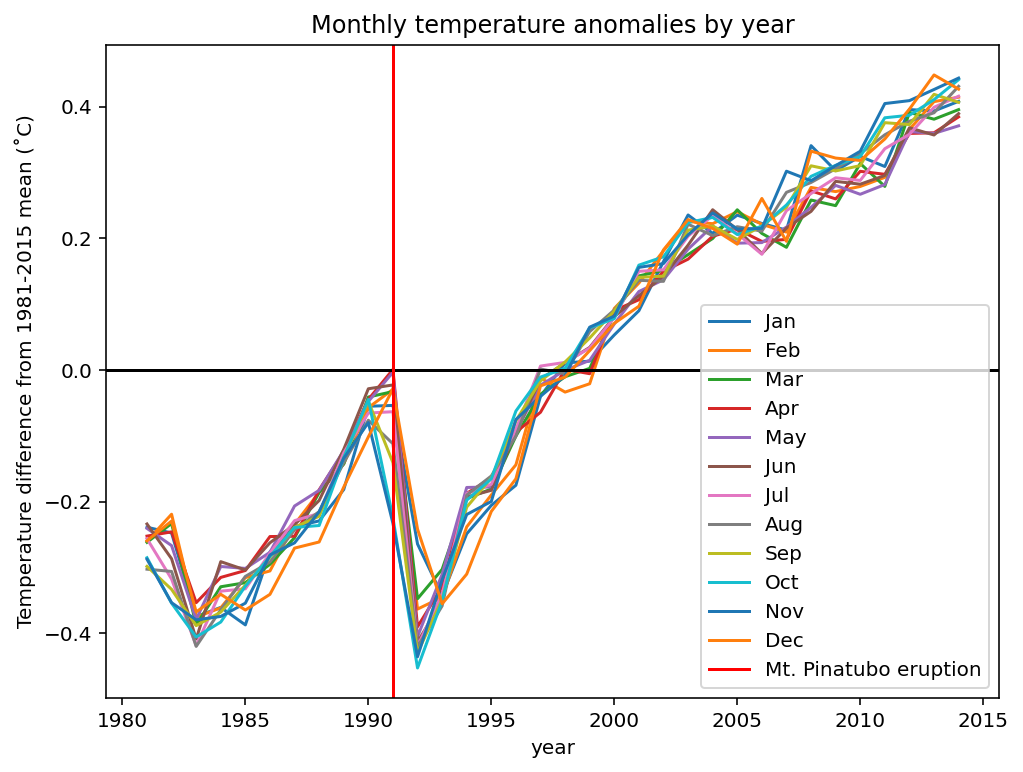

In [254]:
plt.figure(figsize=(8,6))
for i in range(1,13):
    plt.plot(monthanomalies[0,:],monthanomalies[i,:],label=months[i-1])
    plt.axhline(y=0.0,color='k')
plt.title('Monthly temperature anomalies by year')
plt.xlabel('year')
plt.ylabel('Temperature difference from 1981-2015 mean (˚C)')
plt.axvline(x=1991,color='red',label='Mt. Pinatubo eruption')
plt.legend()
plt.show()

(1.1, 1.5)

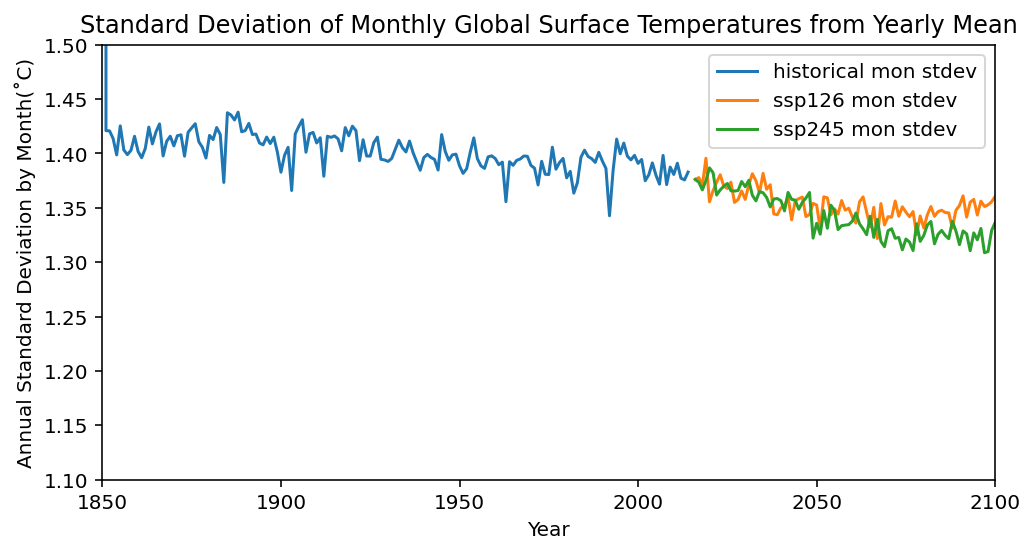

In [242]:
plt.figure(figsize=(8,4))
#plt.plot(tas_exp[0][0,:],stddevs)
plt.plot(tas_exp[0][0,:165],stddevs[0,:165],label = 'historical mon stdev')
for j in range(1,3): 
    plt.plot(tas_exp[j][0,166:],stddevs[j,166:],label = names[j]+' mon stdev')
plt.title('Standard Deviation of Monthly Global Surface Temperatures from Yearly Mean')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Annual Standard Deviation by Month(˚C)')
plt.xlim(1850,2100)
plt.ylim(1.1,1.5)

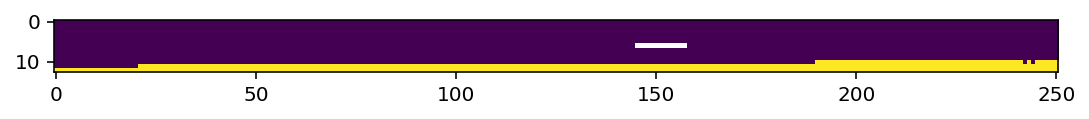

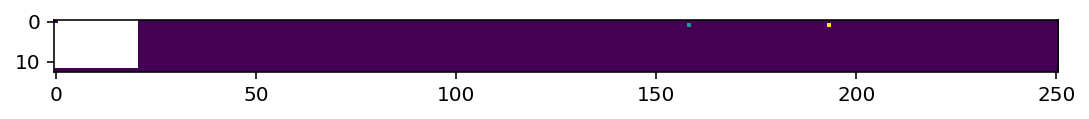

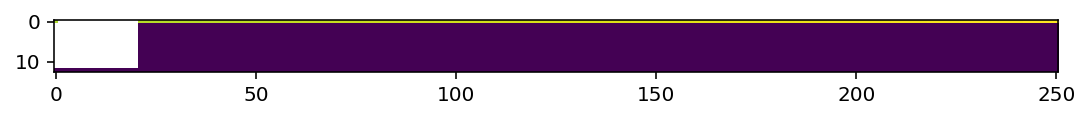

In [58]:
for i in range(3):
    plt.figure(figsize=(9,2))
    plt.imshow(tas_exp[i])
    plt.show()

(552024, 4)


<ipython-input-50-6d3bd0cf9b35>:10: RuntimeWarning: Mean of empty slice
  montemp = np.nanmean(mongroup['tas'])


(184008,)
(184008, 4)


<ipython-input-50-6d3bd0cf9b35>:10: RuntimeWarning: Mean of empty slice
  montemp = np.nanmean(mongroup['tas'])


(184008,)
(184008, 4)


<ipython-input-50-6d3bd0cf9b35>:10: RuntimeWarning: Mean of empty slice
  montemp = np.nanmean(mongroup['tas'])


(184008,)
(184008, 4)


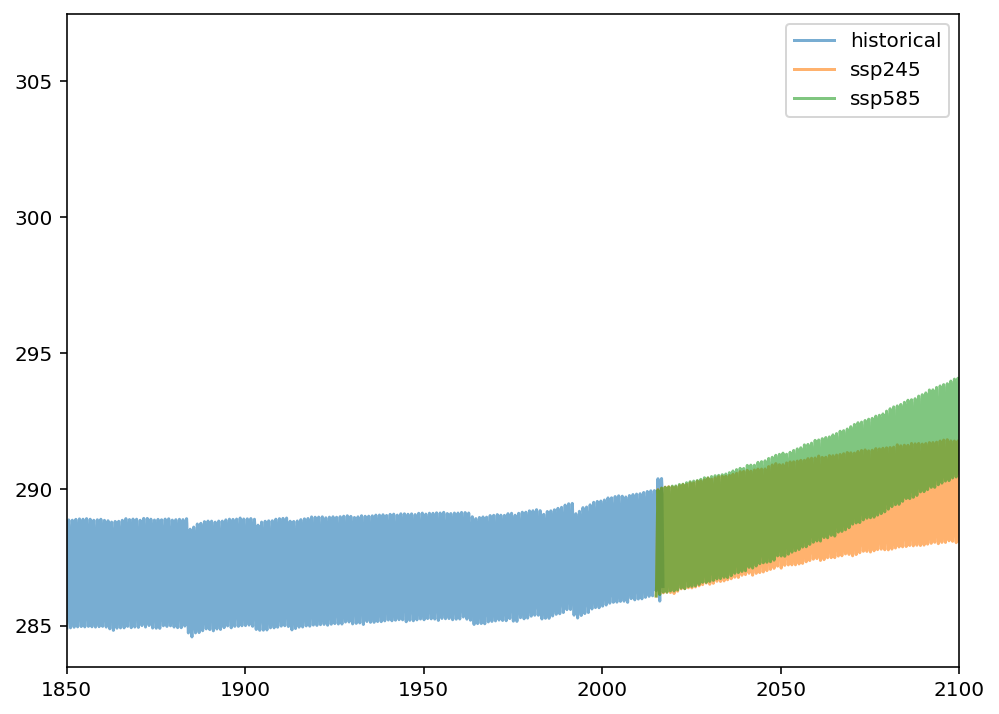

In [50]:
print(df_all.shape)
df_by_exp = df_all.groupby('experiment_id')

plt.figure(figsize=(8,6))
for name, group in df_by_exp:
    group_mon = group.groupby('rawmonth')
    avg_temps = []
    months = []
    for mon, mongroup in group_mon:
        montemp = np.nanmean(mongroup['tas'])
        avg_temps.append(montemp)
        months.append(mon)
    temps = np.array(group['tas'])
    print(temps.shape)
    print(group.shape)
    years = (np.asarray(months)/12)+1850
    plt.plot(years,avg_temps,label=name,alpha=0.6)
    #plt.show()
plt.xlim(1850,2100)
#plt.ylim(270,296)
plt.legend()

In [ ]:
print(df_all['year'].shape)
years = np.array(df_all['year'])
#print(years.shape)
plt.figure(figsize=(20,6))
plt.plot(years,'b.')

In [108]:
print(df_all.shape)
df_by_exp = df_all.groupby('experiment_id')

tas_exp = []
names = []
for name, group in df_by_exp:
    group_mon = group.groupby('rawmonth')
    tas = np.empty((13,251,34))
    for i in range(34):
        tas[0,:,i]=np.arange(1850,2101)
    names.append(name)
    for mon, mongroup in group_mon:
        if mon<3012:
            montemps = np.array(mongroup['tas'])
            i_month = int(mon%12)
            if i_month==0:
                i_month=12
            i_year = int(np.floor(mon/12))
            for i in range(len(montemps)):
                tas[i_month,i_year,i] = montemps[i]
            #if montemp <     
    #print(np.count_nonzero(tas))
    #print(np.count_nonzero(np.isnan(tas)))
    tas_exp.append(tas)
    #years = (np.asarray(months)/12)+1850
    #plt.plot(years,avg_temps,label=name,alpha=0.6)
    #plt.show()

(552024, 4)


In [ ]:
plt.figure(figsize=(20,6))
for name, group in df_by_exp:
    for 
    plt.plot(group['year'],label=name)
plt.legend()